# Importing packages

In [0]:
import numpy as np
import math
from scipy.linalg import hadamard
import statistics as st
import operator
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score
import time
from scipy.stats import unitary_group
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Required functions
Here we define the functions that are necessary for our simulations

In [0]:
# This function generates the nth computational (standard) basis vector in the standard ordering.

# 1. n: Index of the basis vectors.
# 2. m: Number of qubits.

def binvec(n, m):
  ans = []
  for i in range(2**m):
    if i != n:
      ans.append(0)
    else:
      ans.append(1)
  ans = np.array(ans).reshape(2**m,1)
  return ans

In [0]:
#Return a single qubit rotation matrix

# 1. Theta: Angle of rotation

def RotMatCreate(Theta):
  
  return(np.matrix([[math.cos(Theta), (-1 * math.sin(Theta))], [math.sin(Theta), math.cos(Theta)]]))

In [0]:
#Return matrix that rotates about the z axis in Bloch sphere

# 1. Theta: Angle of rotation

def ZRot(Theta):
  
  return(np.matrix([[math.cos(Theta/2) - (1j * math.sin(Theta/2)), 0],[0, math.cos(Theta/2) + (1j * math.sin(Theta/2))]]))

In [0]:
# This function generates separable pure states.

# 1. QubitNo: Number of qubits
# 2. IsDensity: Enter 0 if you want to return the state in normal vector form.
#               Enter 1 if you want to return the flattedned density matrix of the state.
#               Enter 2 if you want to return both vector and flatted density forms.

def GenSepState(QubitNo, IsDensity):
  
  FinalState = np.matrix([[1]])
    
  for i in range(QubitNo):
    FinalState = np.kron(FinalState,(2*np.random.random([2,1])-1 + 2j*np.random.random([2,1])-1))    
            
  FinalState = FinalState/np.linalg.norm(FinalState)
  if IsDensity == 1:
    Rho = np.kron(FinalState,np.conj(FinalState.T))
    Rho = Rho.reshape(len(Rho)**2,1)
    return Rho
  elif IsDensity == 2:
    Rho = np.kron(FinalState,np.conj(FinalState.T))
    Rho = Rho.reshape(len(Rho)**2,1)
    return FinalState, Rho
  return FinalState

In [0]:
# This function generates entangled pure states.

# 1. QubitNo: Number of qubits.
# 2. IsMaxEnt: Enter 1 if the state should be maximally entangled.
# 3. IsDensity: Enter 0 if you want to return the state in normal vector form.
#               Enter 1 if you want to return the flattedned density matrix of the state.
#               Enter 2 if you want to return both vector and flatted density forms.

def GenEntState(QubitNo, IsMaxEnt, IsDensity):
  
  if IsMaxEnt == 1:
        
    FinalState = np.zeros([2**QubitNo, 1])
    FinalState[0,0] = 1
    FinalState[-1,0] = 1
    
    RotMat = np.matrix([[1]])
    Thetas = (2*math.pi) * np.random.random(QubitNo)
    Phis = (math.pi) * np.random.random(QubitNo)
    
    Ry = [RotMatCreate(x/2) for x in Thetas]
    Rz = [ZRot(y) for y in Phis]
    MatY = np.matrix([[1]])
    MatZ = np.matrix([[1]])
    
    for i in range(QubitNo):
      MatY = np.kron(MatY, Ry[i])
      MatZ = np.kron(MatZ, Rz[i])

    FinalState = np.matmul(MatZ,np.matmul(MatY,FinalState))

  else:
        
    Re = (2 * np.random.random([2**QubitNo,1])) - 1 
    Im = (2 * np.random.random([2**QubitNo,1])) - 1
    FinalState = Re + 1j*Im
  
        
  FinalState = FinalState/np.linalg.norm(FinalState)
  if IsDensity == 1:
    Rho = np.kron(FinalState,np.conj(FinalState.T))
    Rho = Rho.reshape(len(Rho)**2,1)
    return Rho
  elif IsDensity == 2:
    Rho = np.kron(FinalState,np.conj(FinalState.T))
    Rho = Rho.reshape(len(Rho)**2,1)
    return FinalState, Rho
  return(FinalState)

In [0]:
# This function can generate a pure state with any type of entanglement

# 1. QubitNo: Number of qubits
# 2. EntList: A list of lists denoting which qubits should be entangled. 
#    For example, if qubit 0 and qubit 3 should be entangled and qubit 1 and qubit 4 should be entangled, EnTList should be [[0, 3],[1, 4],[2]]
# 3. IsMaxEntList: A list which denotes whether the required entangelements should be maximal or not. 
#    The length of the list should be same as length of EntList.
#    For example, if EntList = [[0, 3], [1, 4], [2]] and you want qubit 1 and qubit 4 to be maximally entngled, then IsMaxEntList = [0,1,0].
# 4. Isdensity: Enter 1 if you require the state to be returned as a flattened density matrix.

def GenMultiEntState(QubitNo, EntList, IsMaxEntList, IsDensity):
  
  IniState = np.matrix([[1]])
  
  for i in range(len(EntList)):
    
    Temp = GenEntState(len(EntList[i]), IsMaxEntList[i], IsDensity = 0)
    IniState = np.kron(IniState,Temp)  
  
  Index = list(range(1, QubitNo+1))
  E = EntList[0]
  
  for p in range(len(EntList)):
    k = 1
    n = len(E)
    ent = sorted(E)
    for i in range(n,0,-1):
      for j in range(i, ent[n-k]+1):
        IniState = np.matmul(SwapGate(QubitNo, Index[j-1], Index[j]), IniState)
      k += 1
    if p != (len(EntList)-1):
      lis = []
      for u in EntList[:p+1]:
        lis = lis + u
      lis2 = [g + 1 for g in lis]
      Index = [x for x in Index if x not in lis2]
      lis1 = []
      for u in EntList[p+1]:
        count = 0
        for v in lis:
          if v < u:
            count += 1
        lis1.append(u-count)
      E = lis1
  if IsDensity == 1:
    Rho = np.kron(IniState,np.conj(IniState.T))
    Rho = Rho.reshape(len(Rho)**2,1)
    return Rho
  return IniState

In [0]:
#Generate NSep separable states

# 1. NSep: Number of separable states to be generated. 
# 2. QubitNo: Number of qubits
# 3. Label: The label attached to the states for classification purposes.
# 4. IsDensity: Enter 0 if you want to return the state in normal vector form.
#               Enter 1 if you want to return the flattedned density matrix of the state.
#               Enter 2 if you want to return both vector and flatted density forms.

def GenSepData(NSep, QubitNo, Label, IsDensity):
  
  if IsDensity == 0:
    SepData = np.zeros([NSep, 2**QubitNo]) + 1j*np.zeros([NSep, 2**QubitNo])
      
    for i in range(NSep):
      temp = GenSepState(QubitNo, IsDensity)
      SepData[i,:] = temp.T
    SepData = np.concatenate([SepData, Label*np.ones((NSep,1))], axis=1)
  elif IsDensity == 1:
    SepData = np.zeros([NSep, (2**QubitNo) ** 2]) + 1j*np.zeros([NSep, (2**QubitNo) ** 2])
      
    for i in range(NSep):
      temp = GenSepState(QubitNo, IsDensity)
      SepData[i,:] = temp.T
    SepData = np.concatenate([SepData, Label*np.ones((NSep,1))], axis=1)
  else:
    SepData = np.zeros([NSep, 2**QubitNo]) + 1j*np.zeros([NSep, 2**QubitNo])
    SepDataDensity = np.zeros([NSep, (2**QubitNo) ** 2]) + 1j*np.zeros([NSep, (2**QubitNo) ** 2])
    for i in range(NSep):
      temp1, temp2 = GenSepState(QubitNo, IsDensity)
      SepData[i,:] = temp1.T
      SepDataDensity[i,:] = temp2.T
    SepData = np.concatenate([SepData, Label*np.ones((NSep,1))], axis=1)
    SepDataDensity = np.concatenate([SepDataDensity, Label*np.ones((NSep,1))], axis=1)
    return SepData, SepDataDensity
  return SepData

In [0]:
# Generate and return NEnt number of entangled states. 
# These states would be fully entangled, that is, no bipartition of the qubits would result in two separable states.

# 1. NEnt: Number of states to be generated.
# 2. QubitNO: Number of qubits.
# 3. IsMaxEnt: Enter 1 if the states should be maximally entangled.
# 4. Label: The label attached to the states for classification purposes.
# 5. IsDensity: Enter 0 if you want to return the state in normal vector form.
#               Enter 1 if you want to return the flattedned density matrix of the state.
#               Enter 2 if you want to return both vector and flatted density forms.

def GenEntData(NEnt, QubitNo, IsMaxEnt, Label, IsDensity):
  if IsDensity == 0:
    EntData = np.zeros([NEnt, 2**QubitNo]) + 1j*np.zeros([NEnt, 2**QubitNo]) 
      
    for i in range(NEnt):
      
      temp = GenEntState(QubitNo, IsMaxEnt, IsDensity)
      EntData[i,:] = temp.T
    EntData = np.concatenate([EntData, Label*np.ones((NEnt,1))], axis=1)
  elif IsDensity == 1:
    EntData = np.zeros([NEnt, (2**QubitNo) ** 2]) + 1j*np.zeros([NEnt, (2**QubitNo) ** 2])
    for i in range(NEnt):
      
      temp = GenEntState(QubitNo, IsMaxEnt, IsDensity, )
      EntData[i,:] = temp.T
    EntData = np.concatenate([EntData, Label*np.ones((NEnt,1))], axis=1)
  else:
    EntData = np.zeros([NEnt, 2**QubitNo]) + 1j*np.zeros([NEnt, 2**QubitNo])
    EntDataDensity = np.zeros([NEnt, (2**QubitNo) ** 2]) + 1j*np.zeros([NEnt, (2**QubitNo) ** 2])
    for i in range(NEnt):
      temp1, temp2 = GenEntState(QubitNo, IsMaxEnt, IsDensity)
      EntData[i,:] = temp1.T
      EntDataDensity[i,:] = temp2.T
    EntData = np.concatenate([EntData, Label*np.ones((NEnt,1))], axis=1)
    EntDataDensity = np.concatenate([EntDataDensity, Label*np.ones((NEnt,1))], axis=1)
    return EntData, EntDataDensity

  return EntData

In [0]:
# This function can generate a dataset of entangled states.

# 1. N: Number of states to be generated.
# 2. QubitNo: Number of qubits
# 3. EntList: A list of lists denoting which qubits should be entangled. 
#    For example, if qubit 0 and qubit 3 should be entangled and qubit 1 and qubit 4 should be entangled, EnTList should be [[0, 3],[1, 4],[2]]
# 4. IsMaxEntList: A list which denotes whether the required entangelements should be maximal or not. 
#    The length of the list should be same as length of EntList.
#    For example, if EntList = [[0, 3], [1, 4], [2]] and you want qubit 1 and qubit 4 to be maximally entngled, then IsMaxEntList = [0,1,0].
# 5. Label: A label for the entangled states. This label helps while providing the data to the KNN model. It can be any integer.
# 6. Isdensity: Enter 1 if you require the state to be returned as a flattened density matrix.

def GenMultiEntData(N, QubitNo, EntList, IsMaxEntList, Label, IsDensity):
  if IsDensity == 0:
  
    Data = np.zeros([N, 2**QubitNo]) + 1j*np.zeros([N, 2**QubitNo])
    for i in range(N):
      
      Data[i,:] = GenMultiEntState(QubitNo, EntList, IsMaxEntList, IsDensity).T
    
  else:
    Data = np.zeros([N, (2**QubitNo) ** 2]) + 1j*np.zeros([N, (2**QubitNo) ** 2])
    for i in range(N):
      
      Data[i,:] = GenMultiEntState(QubitNo, EntList, IsMaxEntList, IsDensity).T
  Data = np.concatenate([Data, Label*np.ones((N,1))], axis=1)

  return Data

In [0]:
# This function returns the matrix form of a swap gate.

# 1. n: Number of qubits.
# 2. s1: First qubit to be swapped.
# 3. s2: Second qubit to be swapped.

def SwapGate(n, s1, s2):

  if s1 == s2:
    outmat = np.eye(2**n)
  else:  
    X = np.matrix([[0,1], [1,0]])
    outmat = CU(n, X, s1, s2)
    outmat = np.matmul(outmat, CU(n, X, s2, s1))
    outmat = np.matmul(outmat, CU(n, X, s1, s2))
  return(outmat)

In [0]:
# This function returns a list of matriices which can be used to measure a state in he computational basis.

# 1. n: Number of qubits.

def compbasis(n):
  M = []
  for i in range(n):
    M.append(np.outer(np.identity(n)[i],np.identity(n)[i]))
  return(M)

In [0]:
# This function returns the matrix form of a controlled-U gate. 

# 1. QNo: Number of qubits.
# 2. u: The 2x2 unitary matrix U.
# 3. con: Control qubit (Starting from 1 to n)
# 4. tar: Target qubit (Starting from 1 to n)

def CU(QNo, u, con, tar):

  outmat = np.zeros([2**QNo, 2**QNo])
  N = 2**QNo
  con = con - 1
  tar = tar - 1

  for i in range(N):
    TempI = Binary(i, QNo)
    if (TempI[con] == 0):
      outmat[i,i] = 1
    elif (TempI[con] == 1):

      for j in range(N):
        TempJ = Binary(j, QNo)
        if (TempJ[con] == 0):
          continue
        elif(TempJ[con] == 1):
          if TempI[tar] == 0 and TempJ[tar] == 0:
            outmat[i,j] = u[0,0]
    
          if TempI[tar] == 0 and TempJ[tar] == 1:
            outmat[i,j] = u[0,1]
    
          if TempI[tar] == 1 and TempJ[tar] == 0:
            outmat[i,j] = u[1,0]
    
          if TempI[tar] == 1 and TempJ[tar] == 1:
            outmat[i,j] = u[1,1]

  for k in range(QNo):
    if (k == tar or k == con):
      continue
    else:
      for i in range(N):
        TempI = Binary(i, QNo)
        for j in range(N):
          TempJ = Binary(j, QNo)
          if (TempI[k] != TempJ[k]):
            outmat[i,j] = 0
          else:
            continue
            
  return (outmat)

In [0]:
# Function to generate the matrix form of certain controlled-U gates where order of U > 2.
# Note that the target qubits should start right from the control qubit onwards, that is, if control is 1, target should be from 2 onwards.

# 1. TQ: Total number of qubits on which U acts.
# 2. con: Control qubit (starting from 0 to n-1)
# 3. U: Matrix form of U gate.
# 4. remainder: Number of qubits after the target qubits.

def CBigU(TQ, con, U, remainder):
  dim = 2 ** TQ
  qu = int(math.log(U.shape[0], 2))

  binlist = []
  anslist = []
  for i in range(dim):
    temp = Binary(i, TQ)
    if temp[con] == 1:
      anslist.append(np.kron(np.identity(2 ** (TQ-qu)), U)@np.identity(dim)[i])
    else:
      anslist.append(np.identity(dim)[i])
  ansmat = np.vstack(anslist).T
  if remainder != 0:
    ansmat1 = np.kron(ansmat, np.eye(2 ** remainder))
    return ansmat1
  return ansmat

In [0]:
# This function is used for measurement. It returns a dictinoary with outcomes as keys and number of times the outcome occurred as values

# 1. M1: List of matrices for measurement of first qubit alone. sum(M.T-conjugate * M) should be equal to I.
# 2. M2: List of matrices for measurement of M register. Here, we are using POVM measurement an hence sum(M) should be equal to I.
# 3. arr: State to be measured.
# 4. N1: Number of shots of measurement.
# 5. histo: Enter 1 if you want to display the histogram.
# 6. verbose: Enter 1 to display which round of measurement the process currently is in.

def Measure(M1, M2, arr, N1, histo = 0, verbose = 0):
  n1 = len(M1)
  n2 = len(M2)
  ansdict0 = {}
  ansdict1 = {}
  sum0 = 0
  sum1 = 0
  for i in range(len(M2)):
    ansdict0[i] = 0
    ansdict1[i] = 0
  if verbose == 1:
    print('calculating prob1')
  prob = [np.real(np.matmul(np.conj(arr).T * x, arr)[0,0]) for x in M1]
  probz2 = {}
  for j in range(N1):
    if verbose == 1:
      print('meas no {}'.format(j))
    
    ans = np.random.choice(np.arange(n1), p=prob)
    pms = (M1[ans] * arr)/(prob[ans] ** 0.5)
    if ans == 0:
      try:
        probz2[0] 
      except KeyError:
        if verbose == 1:
          print('calculating prob20')
        probz2[0] = [np.real(np.matmul(np.conj(pms).T * conv, pms)[0,0]) for conv in M2]
      ans2 = np.random.choice(np.arange(n2), p=probz2[0])
      ansdict0[ans2] += 1
      sum0 = sum0 + 1
    if ans == 1:
      try:
        probz2[1] 
      except KeyError:
        if verbose == 1:
          print('calculating prob21')
        probz2[1] = [np.real(np.matmul(np.conj(pms).T * conv, pms)[0,0]) for conv in M2]
      ans2 = np.random.choice(np.arange(n2), p=probz2[1])
      ansdict1[ans2] += 1
      sum1 = sum1 + 1
  return(ansdict0, ansdict1, sum0, sum1)

In [0]:
# This function returns the binary form of a decimal number in a list.

# 1. x: Decimal number.
# 2. BitNo: Number of qubits/bits.

def Binary(x, BitNo):
  format(x, 'b').zfill(BitNo)
  Binlist = [int(y) for y in list(format(x, 'b').zfill(BitNo))]
  return Binlist


In [0]:
# This functions runs the whole circuit. It returns the label of the of test point. The label is based on how the states for training are provided.
# For example, if the first 8 are separable and the next 8 are entangled states, then 0 would mean psi is separable and 1 would mean psi is entangled.

# 1. TrainStates: The entangled states to be initalized in the final two registers.
# 2. GateSets: List of gates.
# 3. MeasurementBases: List of measurement bases for both measurements.
# 4. Psi: Test state.
# 4. NMeas: Number of shots of measurement.
# 5. Class: The distribution of data in the trainstates state/training data.
#    For example: If you have 8 separable and 8 entangled states, then Class = [8,8]
# 6. verbose: Enter 1 to display which round of measurement the process currently is in.

def Engine(TrainStates, GateSets, MeasurementBases, Psi, NMeas, Class, k, verbose = 0, histo = 0):  
  if verbose == 1:
    print('Preparing registers')
  
  Reg1 = np.matrix([[1], [0]])
  Reg2 = Psi
  Reg3 = TrainStates
  Reg = np.kron(np.kron(Reg1, Reg2), Reg3)
  
  if verbose == 1:
    print('Gate Multiplication')
  
  step1 = np.matmul(GateSets[0], Reg)
  for i in range(N):
    step1 = np.matmul(GateSets[i + 1], step1)
  step1 = np.matmul(GateSets[0], step1)
  
  if verbose == 1:
    print('Commencing Measurement')
  
  MeasResults0, MeasResults1, sum0, sum1 = Measure(MeasurementBases[0], MeasurementBases[1], step1, NMeas, verbose = verbose, histo = histo)
  MeasResults00 = {k: v / sum0 for k, v in MeasResults0.items()}
  MeasResults11 = {k: v / sum1 for k, v in MeasResults1.items()}
  MeasResults = {}
  for keyy in MeasResults00:
    MeasResults[keyy] = MeasResults00[keyy] - MeasResults11[keyy]
  if histo == 1:
    ml = []
    for key in sorted(MeasResults.keys()):
      ml.append(MeasResults[key])
    plt.subplots(figsize=(9,5))
    
    plt.bar(list(range(16)), ml[:16], 0.8, color=['blue'])
    plt.bar(list(range(16,32)), ml[16:32], 0.8, color=['green'])
    plt.legend(['Separable', 'Maximally entangled'], loc = 'upper right', prop={'size': 14})
    plt.tick_params(labelsize=14)
    plt.show()


    
    
  scores = {}
  cumu = [0] + list(np.cumsum(Class))
  scores = {}
  p = 0 
  for i in range(1, len(cumu)):
    for j in range(cumu[i-1], cumu[i]):

      scores[j] = p
    p += 1
  ans = []
  sorted_x = sorted(MeasResults.items(), key=lambda kv: kv[1], reverse = True)[:k]
  for x in sorted_x:
    ans.append(scores[x[0]])
  Res = max(set(ans), key=ans.count)
  return(Res)

In [0]:
# This functions prepares the gates and bases for measurement and runs the circuit. 

# 1. TrainStates: The entangled states to be initalized in the final two registers.
# 2, TestData: Dataset containing states for testing.
# 2. N: Number of qubits in the test state.
# 3. M: Number of qubits required to store all labels of the training states. If there are T training states, then M = log2(T).
# 4. NMeas: Number of shots of measurement.
# 5. Class: The distribution of data in the trainstates state/training data.
#    For example: If you have 8 separable and 8 entangled states, then Class = [8,8]
# 6. k: The number of nearest neighbours taken for voting. 
# 7. histo: 0 if histogram is to be not printed. 1 if histogram is to be printed 

def QNN(TrainStates, TestData, N, M, NMeas, Class, k, histo = 0):  
  
  TotalQubits = N + N + M + 1
  GateList = []
  HadGate = np.matrix([[1,1],[1, -1]])
  HadGate = HadGate/np.sqrt(2)

  print('Preparing gate1; Hadamard on the firt qubit')
  Gate1 = np.kron(HadGate, np.identity(2**(TotalQubits - 1)))
  GateList.append(Gate1)
  print('Preparing the controlled swap gates')
  TempSwap = np.identity(2**(N + N))
  
  for i in range(N):
    s1 = SwapGate(N + N, i + 1, N + i + 1)
    Gatetemp = CBigU2Last(1 + N + N, 0, s1, remainder = M)
    GateList.append(Gatetemp)

  MeasBasis2 = []
  print('Preparing measurement set for measuring the first register')
  
  Results = []
  c1 = compbasis(2)
  
  MeasBasis1 = [csr_matrix(np.kron(x, np.identity(2**(TotalQubits-1)))) for x in c1]
  
  print('Preparing measurement set for measuring the last register')
  
  c2 = compbasis(2**M)
  for x in c2:
    temp = csr_matrix(np.kron(np.identity(2**(TotalQubits-M)), x))
    temp2 = temp.conj().transpose() 
    MeasBasis2.append(temp2 * temp)
  ke = 1
  
  for x in TestData:
    print('Test state {} out of {}'.format(ke, TestData.shape[0]))
    test = x.reshape((2**N,1))
    Results.append(Engine(TrainStates, GateList, [MeasBasis1, MeasBasis2], test, NMeas, Class, k = k, histo = histo))
    ke += 1
  
  return Results

# Testing
In this section, you may tweak the parameters and have a test run of the simulations. 


## Quantum kNN

In this cell, we prepare the dataset and the state to be initialized in the last two registers for two qubit states. The dataset consists of separable and maximally entangled states.

In [0]:
# Two qubit
N = 2
M = 5
TotalQubits = N + N + M + 1
NMeas = 5000

# Test
NSepT = 15
NEntT = 15
DataSepTest = GenSepData(NSepT, N, 0, 0)
Data12Test = GenEntData(NEntT, N, 1, 1, 0)
DataTest = np.concatenate([DataSepTest, Data12Test], axis = 0)
Data1Test = DataTest[:,:DataTest.shape[1]-1]
YTest = DataTest[:, -1]

# Train
NSep = 2**(M-1)
NEnt = 2**(M-1)
DataSep = GenSepData(NSep, N, 0, 0)
Data12 = GenEntData(NEnt, 2, 1, 1, 0)
Data = np.concatenate([DataSep, Data12], axis = 0)
Data1 = Data[:,:Data.shape[1]-1]
ans = np.zeros(((2**N) * (2**M),1 )) + 1j*np.zeros(((2**N) * (2**M),1))
for i in range(Data1.shape[0]):
  temp = Data1[i].reshape(2**N, 1)
  temp1 = np.kron(temp, binvec(i,M))
  ans = ans + temp1
TrainStates = ans/np.linalg.norm(ans)

The results are now dispayed.

Preparing gate1; Hadamard on the firt qubit
Preparing the controlled swap gates
Preparing measurement set for measuring the first register
Preparing measurement set for measuring the last register
Test state 1 out of 30


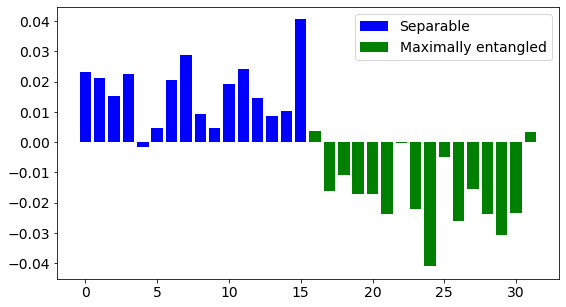

Test state 2 out of 30


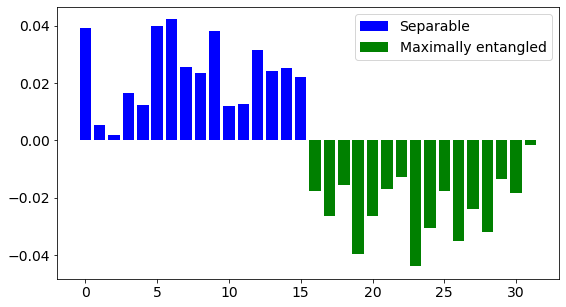

Test state 3 out of 30


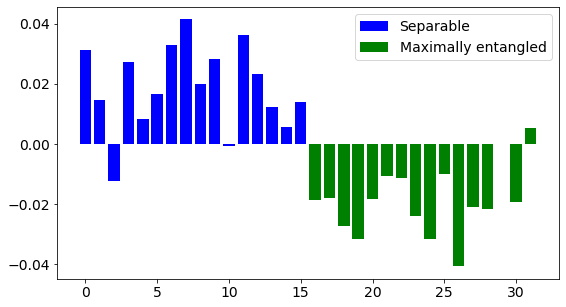

Test state 4 out of 30


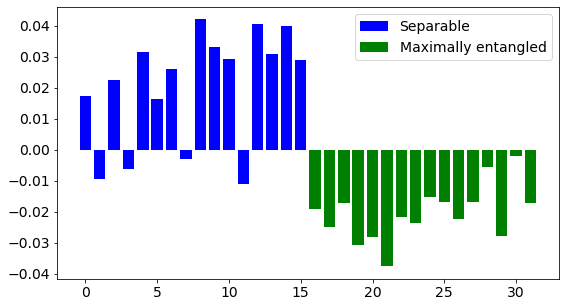

Test state 5 out of 30


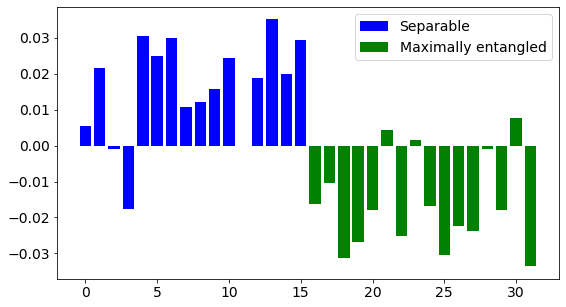

Test state 6 out of 30


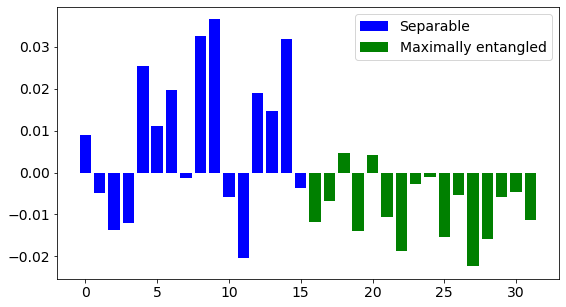

Test state 7 out of 30


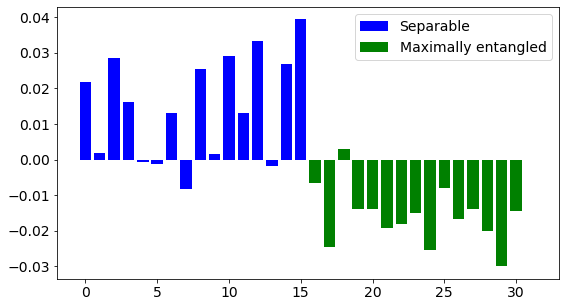

Test state 8 out of 30


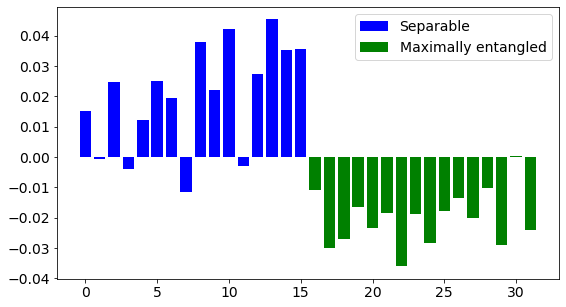

Test state 9 out of 30


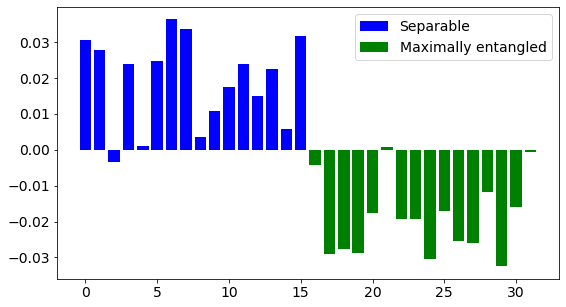

Test state 10 out of 30


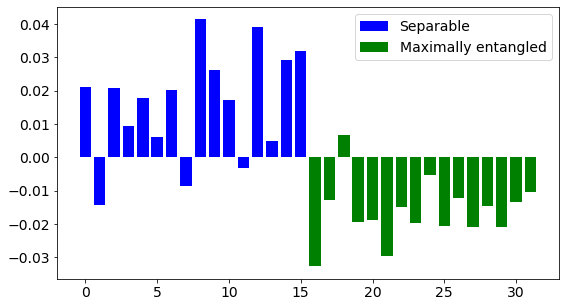

Test state 11 out of 30


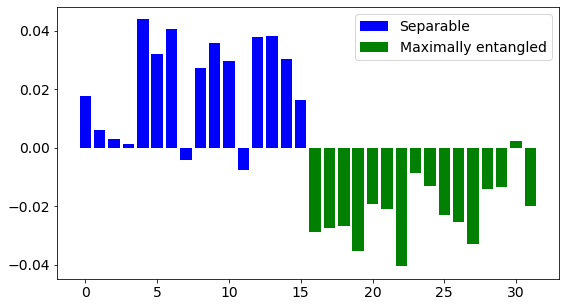

Test state 12 out of 30


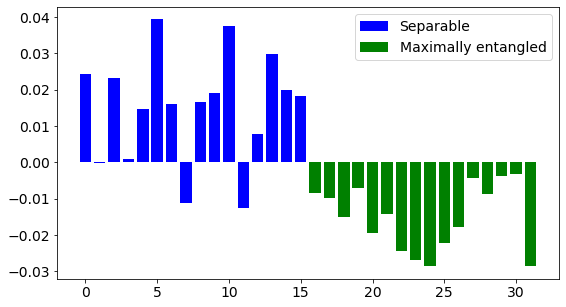

Test state 13 out of 30


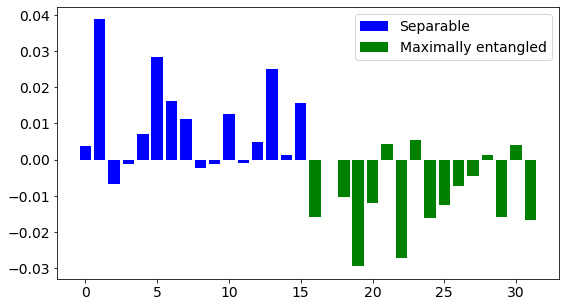

Test state 14 out of 30


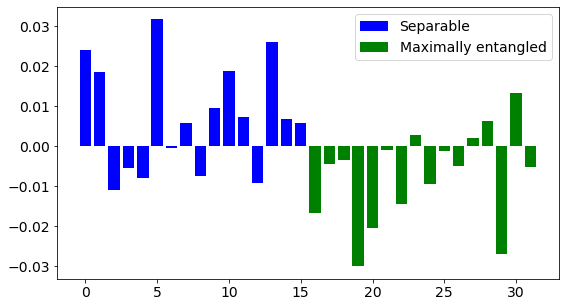

Test state 15 out of 30


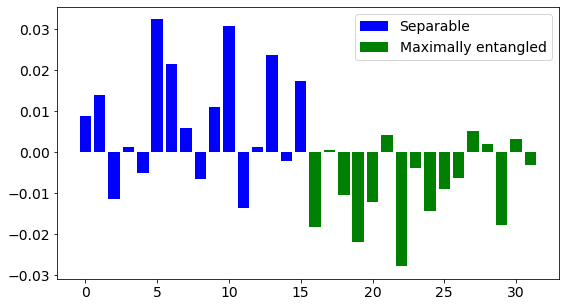

Test state 16 out of 30


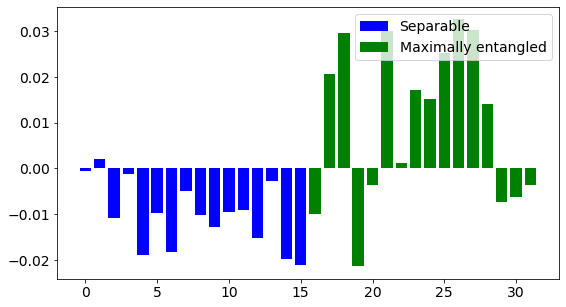

Test state 17 out of 30


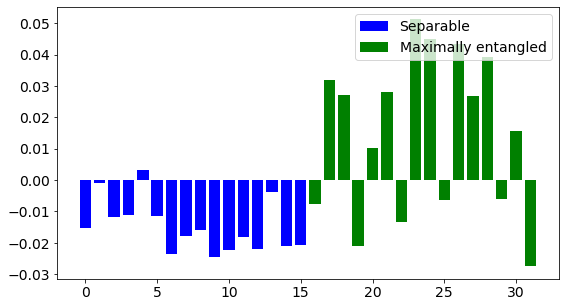

Test state 18 out of 30


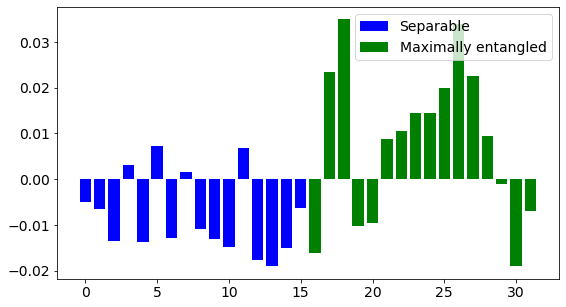

Test state 19 out of 30


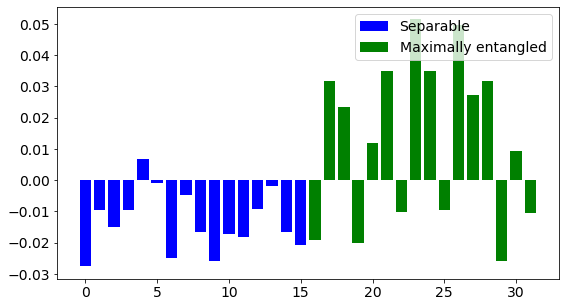

Test state 20 out of 30


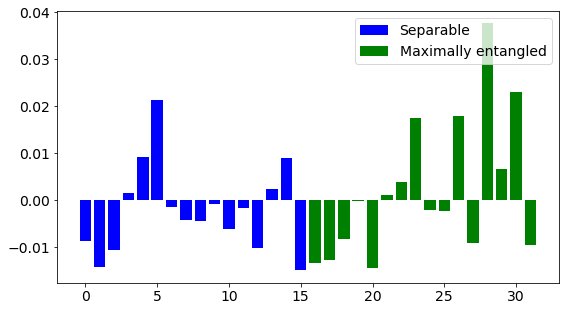

Test state 21 out of 30


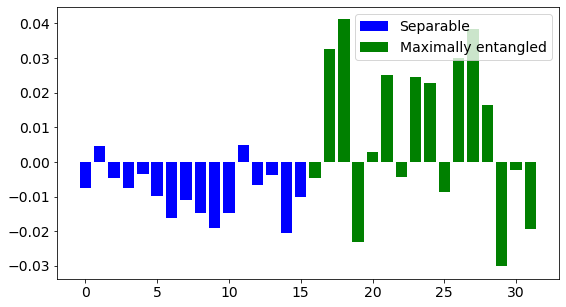

Test state 22 out of 30


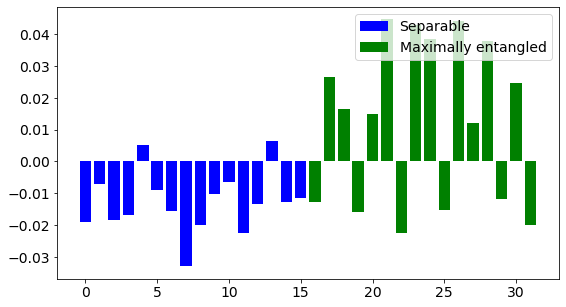

Test state 23 out of 30


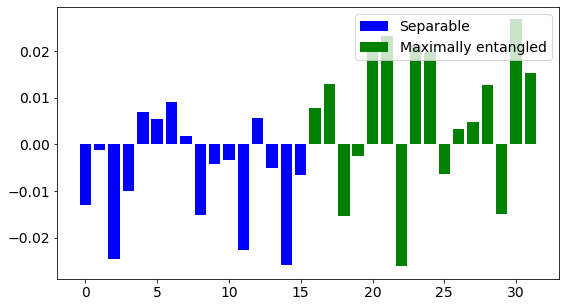

Test state 24 out of 30


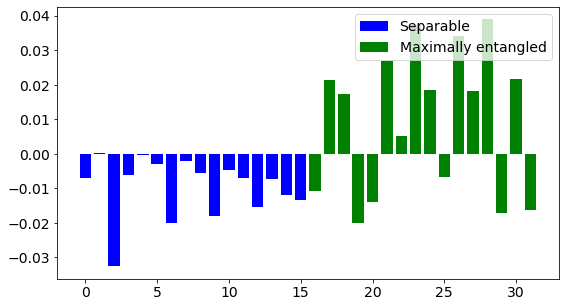

Test state 25 out of 30


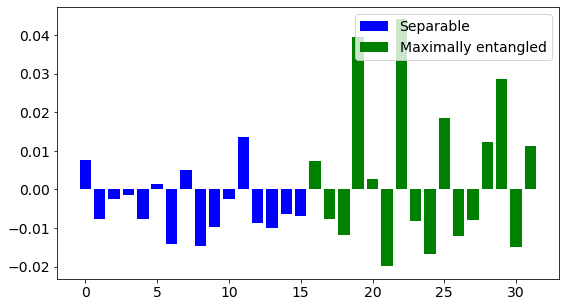

Test state 26 out of 30


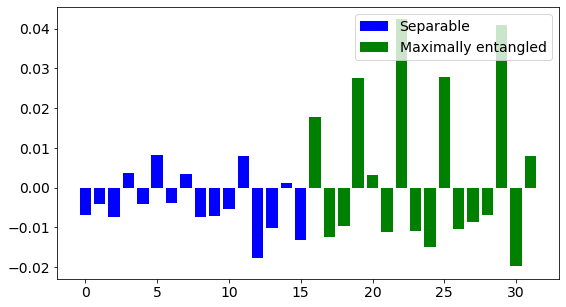

Test state 27 out of 30


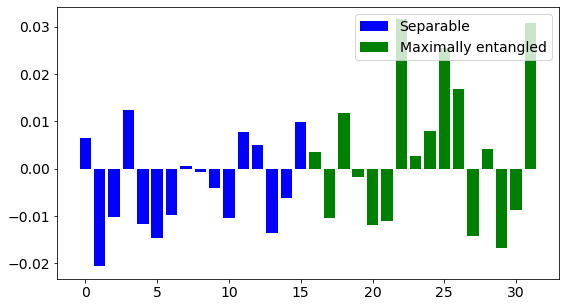

Test state 28 out of 30


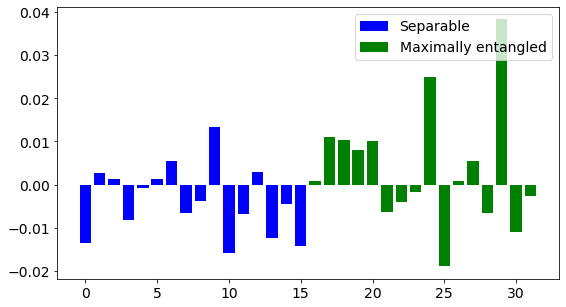

Test state 29 out of 30


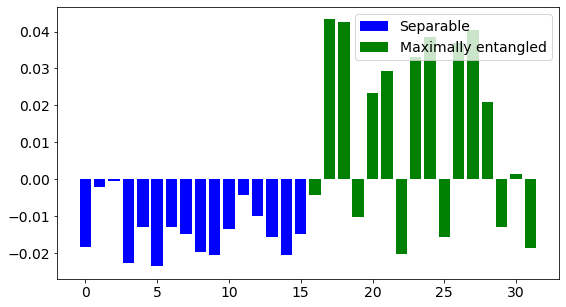

Test state 30 out of 30


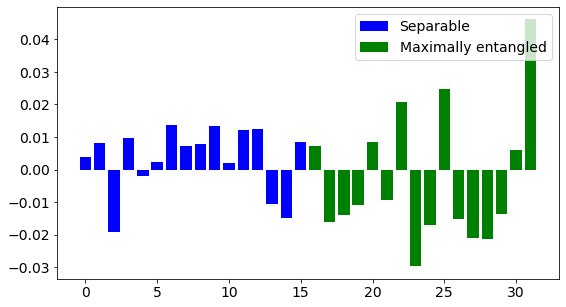

In [0]:
Results = QNN(TrainStates, Data1Test, N, M, NMeas, [2**(M-1),2**(M-1)], k = 3, histo = 1)

Accuracy Score is shown below.

In [0]:
accuracy_score(YTest, Results)

1.0

## Classical KNN

Here we have a test run of the classical kNN algorithm where the classification is done between separable vs entangled states with $1000$ states in each class.

In [0]:
NSep = 1000
NEnt = 1000
n = 2

In [0]:
DataSep = GenSepData(NSep, n, 1, 1)
Data12 = GenEntData(NEnt, n, 0, 0, 1)
Data = np.concatenate([DataSep, Data12], axis = 0)

In [0]:
np.random.shuffle(Data)

In [0]:
DataX = Data[:,:-1]
DataY = Data[:,-1]
DataSplitX = np.concatenate([np.real(DataX), np.imag(DataX)], axis = 1)
DataSplitY = np.real(DataY)
XTrain, YTrain, XTest, YTest = DataSplitX[:-int((NSep+NEnt)/5)], DataSplitY[:-int((NSep+NEnt)/5)], DataSplitX[-int((NSep+NEnt)/5):], DataSplitY[-int((NSep+NEnt)/5):]

In [0]:
NeighComp = KNeighborsClassifier(n_neighbors=3, metric = 'cosine')
NeighComp.fit(XTrain, YTrain)
Ans = NeighComp.predict(XTest)
print("Accuracy = ",accuracy_score(YTest, Ans))
confusion_matrix(YTest, Ans)

Accuracy =  0.935


array([[163,  24],
       [  2, 211]])

# Simulation results
We now present our computational and simulational results. 

## Classical kNN classifier

Here we attempt three classification problems. 

1.   Separable vs maximally entangled states in two qubits.
2.   Separable vs entangled states in two qubits.
3.   Entanglement classification in three qubits where there are 5 classes, which are A-B-C, AB-C, A-BC, AC-B, ABC.

Here a '-' indicates the partitions are separable and a lack of it indicates they are entangled.




### Separable vs Maximally entangled states
Classification is done with 100000 data points in each class. 


In [0]:
NSep = 100000
NEnt = 100000
n = 2

In [0]:
DataSep = GenSepData(NSep, n, 0, 1)
Data12 = GenEntData(NEnt, n, 1, 1, 1)
Data = np.concatenate([DataSep, Data12], axis = 0)

In [0]:
np.random.shuffle(Data)

In [0]:
DataX = Data[:,:-1]
DataY = Data[:,-1]
DataSplitX = np.concatenate([np.real(DataX), np.imag(DataX)], axis = 1)
DataSplitY = np.real(DataY)
XTrain, YTrain, XTest, YTest = DataSplitX[:-int((NSep+NEnt)/5)], DataSplitY[:-int((NSep+NEnt)/5)], DataSplitX[-int((NSep+NEnt)/5):], DataSplitY[-int((NSep+NEnt)/5):]

In [0]:
NeighComp = KNeighborsClassifier(n_neighbors=3, metric = 'cosine')
NeighComp.fit(XTrain, YTrain)
Ans = NeighComp.predict(XTest)
print("Accuracy = ",accuracy_score(YTest, Ans))
confusion_matrix(YTest, Ans)

Accuracy =  1.0


array([[20077,     0],
       [    0, 19923]])

### Separable vs Entangled states

Classification is done with 100000 data points in each class. 



In [0]:
NSep = 100000
NEnt = 100000
n = 2

In [0]:
DataSep = GenSepData(NSep, n, 0, 1)
Data12 = GenEntData(NEnt, n, 0, 1, 1)
Data = np.concatenate([DataSep, Data12], axis = 0)

In [0]:
np.random.shuffle(Data)

In [0]:
DataX = Data[:,:-1]
DataY = Data[:,-1]
DataSplitX = np.concatenate([np.real(DataX), np.imag(DataX)], axis = 1)
DataSplitY = np.real(DataY)
XTrain, YTrain, XTest, YTest = DataSplitX[:-int((NSep+NEnt)/5)], DataSplitY[:-int((NSep+NEnt)/5)], DataSplitX[-int((NSep+NEnt)/5):], DataSplitY[-int((NSep+NEnt)/5):]

In [0]:
NeighComp = KNeighborsClassifier(n_neighbors=3, metric = 'cosine')
NeighComp.fit(XTrain, YTrain)
Ans = NeighComp.predict(XTest)
print("Accuracy = ",accuracy_score(YTest, Ans))
confusion_matrix(YTest, Ans)

Accuracy =  0.985025


array([[19881,     7],
       [  592, 19520]])

### Three qubit entanglement classification

Classification is done with 100000 data points in each class. 


In [0]:
N = 100000
DataSep = GenSepData(N, 3, 0, 1)
Data12 = GenMultiEntData(N, 3, [[0,1],[2]], [0,0], 12, 1)
Data23 = GenMultiEntData(N, 3, [[0],[1,2]], [0,0], 23, 1)
Data31 = GenMultiEntData(N, 3, [[0,2],[1]], [0,0], 13, 1)
Data123 = GenEntData(N, 3, 0, 123, 1)

In [0]:
Data = np.concatenate([DataSep, Data12, Data23, Data31, Data123], axis = 0)

In [0]:
np.random.shuffle(Data)

In [0]:
DataX = Data[:,:-1]
DataY = Data[:,-1]

In [0]:
DataSplitX = np.concatenate([np.real(DataX), np.imag(DataX)], axis = 1)
DataSplitY = np.real(DataY)

In [0]:
XTrain, YTrain, XTest, YTest = \
DataSplitX[:-2000], DataSplitY[:-2000], DataSplitX[-2000:], DataSplitY[-2000:]

In [0]:
NeighComp = KNeighborsClassifier(n_neighbors=3, metric = 'cosine')
NeighComp.fit(XTrain, YTrain)
Ans = NeighComp.predict(XTest)
print("Accuracy = ",accuracy_score(YTest, Ans))
confusion_matrix(YTest, Ans)

Accuracy =  0.889


array([[390,   0,   1,   0,   0],
       [ 12, 388,   7,  10,   0],
       [ 16,  15, 348,  14,   0],
       [ 17,  24,   8, 383,   0],
       [  1,  36,  38,  23, 269]])

##Quantum kNN classifier

We now look at two problems. 


1.   Separable states vs maximally entangled states in two qubits.
2.   Separable states vs entangled states in two qubits.

In both classifications, we have 16 train states in each class. $k$ is chosen to be 3. Simulations are done for $10000$ shots and each result is averaged over 10 such simulations with random generated data.

To compare the efficiency of classical vs quantum kNN, we also compare results with classical kNN implemented over the same data (i.e. 16 data points in each class).

### Separable vs maximally entangled states

In [0]:
acclist1 = [] # accuracies of quantum kNN
acclist2 = [] # accuracies of classical kNN
for av in range(10):
  print('Stage {}'.format(av))
  # Two qubit
  N = 2
  M = 5
  TotalQubits = N + N + M + 1
  NMeas = 10000

  # Test
  NSepT = 15
  NEntT = 15
  DataSepTest, DataSepTestDensity = GenSepData(NSepT, N, 0, 2)
  Data12Test, Data12TestDensity = GenEntData(NEntT, N, 1, 1, 2)
  DataTest = np.concatenate([DataSepTest, Data12Test], axis = 0)
  Data1Test = DataTest[:,:DataTest.shape[1]-1]
  YTest = DataTest[:, -1]

  # Train
  NSep = 2**(M-1)
  NEnt = 2**(M-1)
  DataSep, DataSepDensity = GenSepData(NSep, N, 0, 2)
  Data12, Data12Density = GenEntData(NEnt, 2, 1, 1, 2)
  Data = np.concatenate([DataSep, Data12], axis = 0)
  Data1 = Data[:,:Data.shape[1]-1]
  ans = np.zeros(((2**N) * (2**M),1 )) + 1j*np.zeros(((2**N) * (2**M),1))
  for i in range(Data1.shape[0]):
    temp = Data1[i].reshape(2**N, 1)
    temp1 = np.kron(temp, binvec(i,M))
    ans = ans + temp1
  TrainStates = ans/np.linalg.norm(ans)
  Results = QNN(TrainStates, Data1Test, N, M, NMeas, [2**(M-1),2**(M-1)], 3, histo = 0) #Put histo = 1 for viewing histograms and run the cell again
  acclist1.append(accuracy_score(YTest, Results))

  # Classical
  DataDensity = np.concatenate([DataSepDensity, Data12Density], axis = 0)
  DataX = DataDensity[:,:-1]
  DataY = DataDensity[:,-1]
  DataSplitX = np.concatenate([np.real(DataX), np.imag(DataX)], axis = 1)
  DataSplitY = np.real(DataY)
  NeighComp = KNeighborsClassifier(n_neighbors=3, metric = 'cosine')
  NeighComp.fit(DataSplitX, DataSplitY)
  # Test
  DataTestDensity = np.concatenate([DataSepTestDensity, Data12TestDensity], axis = 0)
  DataXTest = DataTestDensity[:,:-1]
  DataYTest = DataTestDensity[:,-1]
  DataSplitXTest = np.concatenate([np.real(DataXTest), np.imag(DataXTest)], axis = 1)
  DataSplitYTest = np.real(DataYTest)
  AnsClass = NeighComp.predict(DataSplitXTest)
  acclist2.append(accuracy_score(DataSplitYTest, AnsClass))


Stage 0
Preparing gate1; Hadamard on the firt qubit
Preparing the controlled swap gates
Preparing measurement set for measuring the first register
Preparing measurement set for measuring the last register
Test state 1 out of 30
Test state 2 out of 30
Test state 3 out of 30
Test state 4 out of 30
Test state 5 out of 30
Test state 6 out of 30
Test state 7 out of 30
Test state 8 out of 30
Test state 9 out of 30
Test state 10 out of 30
Test state 11 out of 30
Test state 12 out of 30
Test state 13 out of 30
Test state 14 out of 30
Test state 15 out of 30
Test state 16 out of 30
Test state 17 out of 30
Test state 18 out of 30
Test state 19 out of 30
Test state 20 out of 30
Test state 21 out of 30
Test state 22 out of 30
Test state 23 out of 30
Test state 24 out of 30
Test state 25 out of 30
Test state 26 out of 30
Test state 27 out of 30
Test state 28 out of 30
Test state 29 out of 30
Test state 30 out of 30
Stage 1
Preparing gate1; Hadamard on the firt qubit
Preparing the controlled swap ga

In [0]:
sum(acclist1)/10 # Average accuracy of quantum algorithm

0.9566666666666668

In [0]:
sum(acclist2)/10 # Average accuracy of classical algorithm

0.9666666666666668

### Separable vs entangled states

In [0]:
acclist1 = [] # accuracies of quantum algorithm
acclist2 = [] # accuracies of classical algorithm
for av in range(10):
  print('Stage {}'.format(av))
  # Two qubit
  N = 2
  M = 5
  TotalQubits = N + N + M + 1
  NMeas = 10000

  # Test
  NSepT = 15
  NEntT = 15
  DataSepTest, DataSepTestDensity = GenSepData(NSepT, N, 0, 2)
  Data12Test, Data12TestDensity = GenEntData(NEntT, N, 0, 1, 2)
  DataTest = np.concatenate([DataSepTest, Data12Test], axis = 0)
  Data1Test = DataTest[:,:DataTest.shape[1]-1]
  YTest = DataTest[:, -1]

  # Train
  NSep = 2**(M-1)
  NEnt = 2**(M-1)
  DataSep, DataSepDensity = GenSepData(NSep, N, 0, 2)
  Data12, Data12Density = GenEntData(NEnt, 2, 0, 1, 2)
  Data = np.concatenate([DataSep, Data12], axis = 0)
  Data1 = Data[:,:Data.shape[1]-1]
  ans = np.zeros(((2**N) * (2**M),1 )) + 1j*np.zeros(((2**N) * (2**M),1))
  for i in range(Data1.shape[0]):
    temp = Data1[i].reshape(2**N, 1)
    temp1 = np.kron(temp, binvec(i,M))
    ans = ans + temp1
  TrainStates = ans/np.linalg.norm(ans)
  Results = QNN(TrainStates, Data1Test, N, M, NMeas, [2**(M-1),2**(M-1)], 3, histo = 0)
  acclist1.append(accuracy_score(YTest, Results))

  # Classical
  DataDensity = np.concatenate([DataSepDensity, Data12Density], axis = 0)
  DataX = DataDensity[:,:-1]
  DataY = DataDensity[:,-1]
  DataSplitX = np.concatenate([np.real(DataX), np.imag(DataX)], axis = 1)
  DataSplitY = np.real(DataY)
  NeighComp = KNeighborsClassifier(n_neighbors=3, metric = 'cosine')
  NeighComp.fit(DataSplitX, DataSplitY)
  # Test
  DataTestDensity = np.concatenate([DataSepTestDensity, Data12TestDensity], axis = 0)
  DataXTest = DataTestDensity[:,:-1]
  DataYTest = DataTestDensity[:,-1]
  DataSplitXTest = np.concatenate([np.real(DataXTest), np.imag(DataXTest)], axis = 1)
  DataSplitYTest = np.real(DataYTest)
  AnsClass = NeighComp.predict(DataSplitXTest)
  acclist2.append(accuracy_score(DataSplitYTest, AnsClass))


Stage 0
Preparing gate1; Hadamard on the firt qubit
Preparing the controlled swap gates
Preparing measurement set for measuring the first register
Preparing measurement set for measuring the last register
Test state 1 out of 30
Test state 2 out of 30
Test state 3 out of 30
Test state 4 out of 30
Test state 5 out of 30
Test state 6 out of 30
Test state 7 out of 30
Test state 8 out of 30
Test state 9 out of 30
Test state 10 out of 30
Test state 11 out of 30
Test state 12 out of 30
Test state 13 out of 30
Test state 14 out of 30
Test state 15 out of 30
Test state 16 out of 30
Test state 17 out of 30
Test state 18 out of 30
Test state 19 out of 30
Test state 20 out of 30
Test state 21 out of 30
Test state 22 out of 30
Test state 23 out of 30
Test state 24 out of 30
Test state 25 out of 30
Test state 26 out of 30
Test state 27 out of 30
Test state 28 out of 30
Test state 29 out of 30
Test state 30 out of 30
Stage 1
Preparing gate1; Hadamard on the firt qubit
Preparing the controlled swap ga

In [0]:
sum(acclist1)/10 # Average accuracy of quantum algorithm

0.8066666666666666

In [0]:
sum(acclist2)/10 # Average accuracy of classical algorithm

0.8099999999999999